In [1]:
import matplotlib.pyplot as plt
import numpy as np
import  pandas as pd
import datetime
from lmfit import Parameters, fit_report, minimize
from scipy.integrate import odeint

In [2]:
# state population dictionary
population = { 'New York': 19378104 }

In [3]:
# method to retrieve COVID19 data from Johns Hopkins website
def get_data():
    # read John Hopkins data from Github
    base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

    # deaths_global = pd.read_csv(base_url + 'time_series_covid19_deaths_global.csv')
    deaths_us = pd.read_csv(base_url + 'time_series_covid19_deaths_US.csv')

    # get latest or current date from data set(s)
    latest_date = deaths_us.columns.values[-1]

    # aggregate data by state (separate highest and lowest states)
    us_drop_columns = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key']
    deaths_us.drop(us_drop_columns + ['Population'], axis=1, inplace=True)
    deaths_us_sorted = deaths_us.groupby('Province_State').agg('sum').sort_values(by=latest_date, ascending=False)

    # only consider states with deaths greater than 50
    us_deaths = deaths_us_sorted[deaths_us_sorted[latest_date] > 50].T
    states = us_deaths.columns.values
    # print(states)

    # set x axis numpy arrays
    num_days = us_deaths.shape[0]
    tdata = np.linspace(0, num_days - 1, num_days)  # x data for curve fit
    ydata = us_deaths['New York'].values
    return tdata, ydata

In [4]:
# function for SEIR viral transmission model (system of nonlinear ODE's)
def fun(y, t, alpha, beta, gamma, delta, lam, kappa, inflect_date, N=population['New York']):
    
    # S=Susceptible; E=Exposed; I=Infected; Q=Quarantined; R=Recovered; D=Deaths; P=Insusceptible
    S, E, I, Q, R, D, P = y
    
    # α=protection rate, β=infection rate, γ=inverse average latent time, δ=inverse average quarantine time,
    # λ=time-dependent cure rate, κ=time-dependent mortality rate
    dSdt = -beta * S * I / N - alpha * S
    dEdt = beta * S * I / N - gamma * E
    dIdt = gamma * E - delta * I
    dQdt = delta * I - lam * Q - kappa * Q
    dRdt = lam * Q
    dDdt = kappa * Q
    dPdt = alpha * S
    
    # inflect_date reflects best date to turn on model (determined in data fit); can be thought of as when
    # viral transmission goes exponential
    if t < inflect_date:
        # model is OFF - all gradients set to zero
        dSdt = dEdt = dIdt = dQdt = dRdt = dDdt = dPdt = 0
        
    return [dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt]

In [5]:
# function used by lmfit in minimization problem to find model coefficients and inflect_date
def residual(pars, t, data=None, eps=None):
    
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    alpha = parvals['alpha']
    beta = parvals['beta']
    gamma = parvals['gamma']
    delta = parvals['delta']
    lam = parvals['lam']
    kappa = parvals['kappa']
    inflect_date = parvals['inflect_date']
    # define model
    y0 = [0.9 * population['New York'], 0, 0.01 * population['New York'], 0, 0, 0, 0]
    sol = odeint(fun, y0, t, args=(alpha, beta, gamma, delta, lam, kappa, inflect_date))
    # print(model)

    # return residuals - fit to data is done with NY State COVD19 death data
    if data is None:
        return sol[:, 5]
    if eps is None:
        return sol[:, 5] - data
    return (sol[:, 5] - data) / eps

In [6]:
# set lmfit minimization parameters that will be estimated (include parameter ranges)
fit_params = Parameters()
fit_params.add('alpha', value=0.04, min=0.01, max=0.09)
fit_params.add('beta', value=2.4, min=1.0, max=4.0)
fit_params.add('gamma', value=0.13, min=0.05, max=0.5)
fit_params.add('delta', value=0.5, min=0.05, max=1.0)
fit_params.add('lam', value=2.4, min=1.0, max=5.0)
fit_params.add('kappa', value=0.005, min=0.001, max=0.01)
fit_params.add('inflect_date', value=60.0, min=50, max=70)

# retrieve Johns Hopkins COVID19 data
xdata, ydata = get_data()
# perform minimization problem with lmfit
results = minimize(residual, fit_params, args=(xdata[0: -1],), kws={'data': ydata[0: -1]})
print(fit_report(results))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 122
    # variables        = 7
    chi-square         = 13719566.3
    reduced chi-square = 119300.577
    Akaike info crit   = 1432.89813
    Bayesian info crit = 1452.52628
[[Variables]]
    alpha:         0.04358375 +/- 2.8566e-04 (0.66%) (init = 0.04)
    beta:          2.97351500 +/- 0.85672645 (28.81%) (init = 2.4)
    gamma:         0.08158738 +/- 0.01213320 (14.87%) (init = 0.13)
    delta:         0.45028904 +/- 0.23432374 (52.04%) (init = 0.5)
    lam:           1.94248226 +/- 5.92286730 (304.91%) (init = 2.4)
    kappa:         0.00611800 +/- 0.01823350 (298.03%) (init = 0.005)
    inflect_date:  58.2178215 +/- 0.37019601 (0.64%) (init = 60)
[[Correlations]] (unreported correlations are < 0.100)
    C(lam, kappa)          =  0.999
    C(delta, lam)          = -0.954
    C(delta, kappa)        = -0.949
    C(beta, kappa)         = -0.824
    C(beta, delta)         =  0.82

In [7]:
# rerun model with fit parameters for display
alpha = results.params['alpha'].value
beta = results.params['beta'].value
gamma = results.params['gamma'].value
delta = results.params['delta'].value
lam = results.params['lam'].value
kappa = results.params['kappa'].value
inflect_date = results.params['inflect_date'].value

print(results.params)
print("\nalpha={:0.4f}, beta={:0.4f}, gamma={:0.4f}, delta={:0.4f}, lam={:0.4f}, kappa={:0.6f}, inflect_date={:0.1f}".format(alpha, beta, gamma, delta, lam, kappa, inflect_date))

y0 = [0.9 * population['New York'], 0, 0.01 * population['New York'], 0, 0, 0, 0]
numdates = 130
t = np.linspace(0, numdates - 1, numdates)
sol = odeint(fun, y0, t, args=(alpha, beta, gamma, delta, lam, kappa, inflect_date))

base = datetime.datetime(2020, 1, 22)
arr = np.array([base + datetime.timedelta(days=i) for i in range(numdates)])  # x data as dates for plots
print("actual inflection date={}".format(arr[int(inflect_date)].strftime('%d %B %Y')))

Parameters([('alpha', <Parameter 'alpha', value=0.04358375076567741 +/- 0.000286, bounds=[0.01:0.09]>), ('beta', <Parameter 'beta', value=2.9735149964514047 +/- 0.857, bounds=[1.0:4.0]>), ('gamma', <Parameter 'gamma', value=0.08158738219723927 +/- 0.0121, bounds=[0.05:0.5]>), ('delta', <Parameter 'delta', value=0.4502890367825282 +/- 0.234, bounds=[0.05:1.0]>), ('lam', <Parameter 'lam', value=1.9424822594647344 +/- 5.92, bounds=[1.0:5.0]>), ('kappa', <Parameter 'kappa', value=0.006118000320657577 +/- 0.0182, bounds=[0.001:0.01]>), ('inflect_date', <Parameter 'inflect_date', value=58.21782151772568 +/- 0.37, bounds=[50:70]>)])

alpha=0.0436, beta=2.9735, gamma=0.0816, delta=0.4503, lam=1.9425, kappa=0.006118, inflect_date=58.2
actual inflection date=20 March 2020


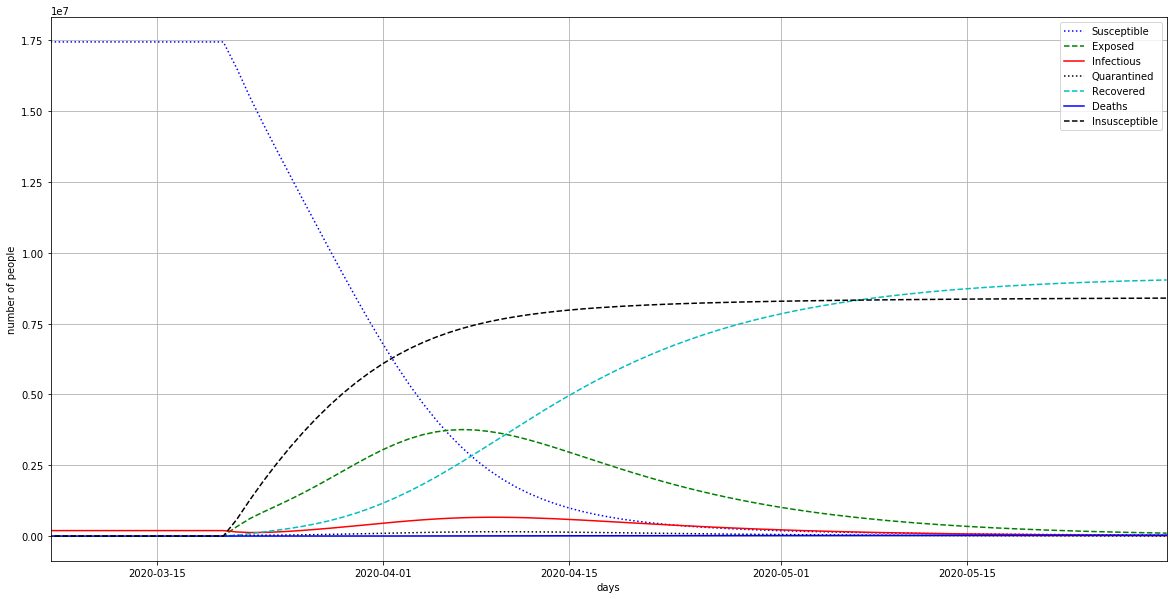

In [8]:
# plot results
fig = plt.figure(figsize=(20, 10))
plt.plot(arr, sol[:, 0], 'b', label='Susceptible', linestyle=':')
plt.plot(arr, sol[:, 1], 'g', label='Exposed', linestyle='--')
plt.plot(arr, sol[:, 2], 'r', label='Infectious')
plt.plot(arr, sol[:, 3], 'k', label='Quarantined', linestyle=':')
plt.plot(arr, sol[:, 4], 'c', label='Recovered', linestyle='--')
plt.plot(arr, sol[:, 5], 'b', label='Deaths')
plt.plot(arr, sol[:, 6], 'k', label='Insusceptible', linestyle='--')
plt.xlim(arr[45], arr[-1])
plt.legend(loc='best')
plt.xlabel('days')
plt.ylabel('number of people')
plt.grid()
plt.show()

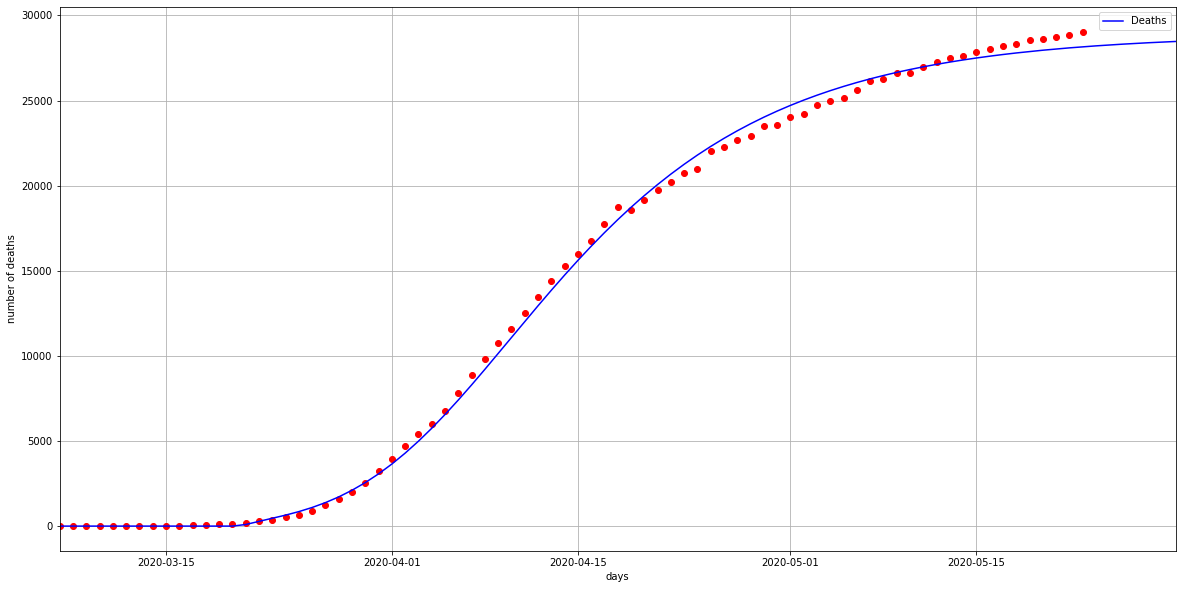

In [9]:
# plot COVID19 deaths vs actuals
fig = plt.figure(figsize=(20, 10))
plt.plot(arr[0: len(ydata)], ydata, 'ro')
plt.plot(arr, sol[:, 5], 'b', label='Deaths')
plt.legend(loc='best')
plt.xlabel('days')
plt.ylabel('number of deaths')
plt.xlim(arr[45], arr[-1])
plt.grid()
plt.show()